# Making prediction model
# EDA

In [3]:
import glob
import os
import pandas as pd
import numpy as np
import scipy, sklearn
from  sklearn.preprocessing import OneHotEncoder as OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost

from  matplotlib import pyplot as plt
from sklearn.preprocessing import normalize


In [3]:
# We need to make unique ids for each estate 
# and take into account reselling - count how many times estate were met

In [5]:
#### Categorical features ####

In [6]:
df = pd.read_csv('/Users/a.evdakimov/Transactions.csv')


#df = df[df['actual_worth'] <= 1000000]


df_ = df[
    ['instance_date',
    'procedure_name_en',
   'property_type_en',
   'property_sub_type_en',
   'property_usage_en',
   'reg_type_en',
   'area_name_en',
   'building_name_en',
   'project_name_en',
   'master_project_en',
   'nearest_landmark_en',
   'nearest_metro_en',
   'nearest_mall_en',
   'rooms_en',
   'has_parking',
   'procedure_area',
    'actual_worth',
    'meter_sale_price']
  ]

df_ = df_.sort_values(by='instance_date')
df_ = df_.dropna()

df_['year'] = df_['instance_date'].apply(lambda x: x[-4:])
df_sell = df_[df_['procedure_name_en'] == 'Sell']


#df_sell = df_sell[df_sell['property_sub_type_en'] == 'Shop']
#df_sell[(df_sell['actual_worth'] <= 1000000) & (df_sell['actual_worth'] >= 100000)]

df_sell_clean = df_sell[
    [
        'property_sub_type_en',
         'property_usage_en', 
         'nearest_landmark_en',
        'nearest_metro_en',
        'nearest_mall_en',
        'rooms_en',
        'has_parking',
        'procedure_area',
        'year',
        'actual_worth',
       'area_name_en',
       'building_name_en',
       'project_name_en',
        
]]

OH_encoder = OneHotEncoder(handle_unknown='ignore',
                           sparse_output = False,
                          dtype = int)

df_sell_clean_ohe = df_sell_clean[
    [
                                 'property_sub_type_en',
                                  'property_usage_en',
                                  'nearest_landmark_en',
                                  'nearest_metro_en',
                                  'nearest_mall_en',
                                  'rooms_en',
                                  'has_parking',
        
                                  'area_name_en',
                                   'building_name_en',
                                   'project_name_en',
        
]]

In [7]:
# Try to split by year. Each year is a fold for cross validation
# Fit model on n folds and test on n+1 fold

In [8]:
# tmp = df_['actual_worth'].values
# tmp_norm = df_['actual_worth'].values / df_['actual_worth'].values.max()
# tmp_std = ((tmp - tmp.mean())/tmp.std())

In [9]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(df_sell_clean_ohe))

# One-hot encoding removed index; put it back
OH_cols_train.index = df_sell_clean.index
#OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
numeric_X_train = df_sell_clean.drop(df_sell_clean_ohe, axis=1)

# Add one-hot encoded columns to numerical features
new_X_train = pd.concat([numeric_X_train, OH_cols_train], axis=1)
#new_X_valid = pd.concat([numeric_X_valid, OH_cols_valid], axis=1)

#print(new_X_train)

In [10]:
Y_train = new_X_train[new_X_train['year'].isin([
                                            '2022',
                                          '2021',
                                         '2020',
                                         '2019',
                                         '2018',
                                         '2017',
                                         '2016'                                      
                                       ]
                                      )]['actual_worth']


X_train = new_X_train[new_X_train['year'].isin([
                                            '2022',
                                          '2021',
                                         '2020',
                                         '2019',
                                         '2018',
                                         '2017',
                                         '2016'
                                               ]
                                              )]
                                              
# X_test = new_X_train[new_X_train['year'] == '2023']
Y_test = new_X_train[new_X_train['year'] == '2023']['actual_worth']
X_test = new_X_train[new_X_train['year'] == '2023']


#X_train = new_X_train

X_train.drop(columns = ['year','actual_worth'], inplace = True)
X_test.drop(columns = ['year','actual_worth'], inplace = True)

# X_train.drop(columns = 'year', inplace = True)
# X_test.drop(columns = 'year', inplace = True)



/var/folders/_g/j20bjn4s0h39l0xcv3ph8w280000gq/T/ipykernel_27036/2786279964.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns = ['year','actual_worth'], inplace = True)
/var/folders/_g/j20bjn4s0h39l0xcv3ph8w280000gq/T/ipykernel_27036/2786279964.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns = ['year','actual_worth'], inplace = True)


In [11]:
# df_tmp = df_[(df_['year'] == '2018') & \
#     (df_['procedure_name_en'] == 'Sell') & \
#    (df_['property_type_en'] == 'Unit')]

In [12]:
#df_tmp.groupby('procedure_area').count().head(50)

In [13]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [52]:
# X_train_max = np.max(X_train[:,0])
# X_test_max = np.max(X_test[:,0])

# X_train[:,0] = X_train[:,0] / X_train_max
# X_test[:,0] = X_test[:,0] / X_test_max


# Y_train_max = np.max(Y_train)
# Y_test_max = np.max(Y_test)

# Y_train = Y_train / Y_train_max
# Y_test = Y_test / Y_test_max



In [14]:
lr = LinearRegression()

regressor = DecisionTreeRegressor(max_depth=50)

xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=20, eta=0.1, subsample=0.7, colsample_bytree=0.8)

rf = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=47)

In [15]:
X_train

array([[190.17,   1.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [116.07,   1.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [ 67.46,   1.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       ...,
       [175.53,   1.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [187.64,   0.  ,   1.  , ...,   0.  ,   0.  ,   0.  ],
       [ 43.59,   1.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]])

In [16]:
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
mean_absolute_error(Y_pred, Y_test)
print('LR_MAE: ',  mean_absolute_error(Y_pred, Y_test))

regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)
mean_absolute_error(Y_pred, Y_test)
print('DecisionTree_MAE: ',  mean_absolute_error(Y_pred, Y_test))

xgb.fit(X_train, Y_train)
Y_pred = xgb.predict(X_test)
mean_absolute_error(Y_pred, Y_test)
print('XGB_MAE: ',  mean_absolute_error(Y_pred, Y_test))

rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
mean_absolute_error(Y_pred, Y_test)
print('RF_MAE: ',  mean_absolute_error(Y_pred, Y_test))


LR_MAE:  14106798413204.416
DecisionTree_MAE:  471867.78580003104
XGB_MAE:  442947.41607495485
RF_MAE:  457935.42476467125


In [56]:
df_.groupby('property_sub_type_en').count()

,instance_date,procedure_name_en,property_type_en,property_usage_en,reg_type_en,area_name_en,building_name_en,project_name_en,master_project_en,nearest_landmark_en,nearest_metro_en,nearest_mall_en,rooms_en,has_parking,procedure_area,actual_worth,meter_sale_price,year
property_sub_type_en,,,,,,,,,,,,,,,,,,
Flat,343632,343632,343632,343632,343632,343632,343632,343632,343632,343632,343632,343632,343632,343632,343632,343632,343632,343632
Gymnasium,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
Hotel Apartment,18201,18201,18201,18201,18201,18201,18201,18201,18201,18201,18201,18201,18201,18201,18201,18201,18201,18201
Hotel Rooms,8168,8168,8168,8168,8168,8168,8168,8168,8168,8168,8168,8168,8168,8168,8168,8168,8168,8168
Office,42473,42473,42473,42473,42473,42473,42473,42473,42473,42473,42473,42473,42473,42473,42473,42473,42473,42473
Shop,3722,3722,3722,3722,3722,3722,3722,3722,3722,3722,3722,3722,3722,3722,3722,3722,3722,3722
Show Rooms,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
Store,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39


In [777]:
#plt.hist(Y_test, bins=100)

In [1095]:
# Try to separate dataset

In [200]:
df_sell['property_sub_type_en'].unique()

array(['Flat', 'Office', 'Shop', 'Hotel Apartment', 'Hotel Rooms',
       'Store', 'Show Rooms'], dtype=object)

In [351]:
df_sell_office = df_sell[df_sell['property_sub_type_en'] == 'Flat']

In [352]:
# Percentile cut

In [365]:
df_sell_office = df_sell_office[(df_sell_office.actual_worth < df_sell_office.actual_worth.quantile(.80)) \
                                & (df_sell_office.actual_worth > df_sell_office.actual_worth.quantile(.10))]

In [366]:
# Trying to work only with OFFICE type 

In [367]:
df_sell_office_clean = df_sell_office[
    [
#        'property_sub_type_en',
         'property_usage_en', 
         'nearest_landmark_en',
        'nearest_metro_en',
        'nearest_mall_en',
        'rooms_en',
        'has_parking',
        'procedure_area',
        'year',
        'actual_worth',
       'area_name_en',
       'building_name_en',
       'project_name_en',
        
]]

OH_encoder = OneHotEncoder(handle_unknown='ignore',
                           sparse_output = False,
                          dtype = int)

df_sell_office_clean_ohe = df_sell_office_clean[
    [
#                                 'property_sub_type_en',
                                  'property_usage_en',
                                  'nearest_landmark_en',
                                  'nearest_metro_en',
                                  'nearest_mall_en',
                                  'rooms_en',
                                  'has_parking',
                                  'area_name_en',
                                   'building_name_en',
                                   'project_name_en',
        
]]

In [368]:
df_sell_office_clean_ohe

,property_usage_en,nearest_landmark_en,nearest_metro_en,nearest_mall_en,rooms_en,has_parking,area_name_en,building_name_en,project_name_en
521760,Residential,Sports City Swimming Academy,Jumeirah Lakes Towers,Marina Mall,2 B/R,1,Al Thanyah Fifth,Bonnington,BONNINGTON TOWER HOTEL & RESIDENCE DUBAI
193605,Residential,Sports City Swimming Academy,Jumeirah Lakes Towers,Marina Mall,2 B/R,1,Al Thanyah Fifth,Bonnington,BONNINGTON TOWER HOTEL & RESIDENCE DUBAI
1016984,Residential,Sports City Swimming Academy,Jumeirah Lakes Towers,Marina Mall,2 B/R,1,Al Thanyah Fifth,AL SHERA,ALSHERA TOWER
1064465,Residential,Sports City Swimming Academy,Jumeirah Lakes Towers,Marina Mall,2 B/R,1,Al Thanyah Fifth,AL SHERA,ALSHERA TOWER
15662,Residential,Sports City Swimming Academy,Jumeirah Lakes Towers,Marina Mall,1 B/R,1,Al Thanyah Fifth,Bonnington,BONNINGTON TOWER HOTEL & RESIDENCE DUBAI
...,...,...,...,...,...,...,...,...,...
188995,Residential,Motor City,Sharaf Dg Metro Station,Mall of the Emirates,1 B/R,1,Al Barshaa South Third,The Wings - B,THE WINGS
499631,Residential,Motor City,Sharaf Dg Metro Station,Mall of the Emirates,2 B/R,1,Al Barshaa South Third,The Wings - B,THE WINGS
380930,Residential,Motor City,Sharaf Dg Metro Station,Mall of the Emirates,2 B/R,1,Al Barshaa South Third,The Wings - B,THE WINGS
360912,Residential,Motor City,Sharaf Dg Metro Station,Mall of the Emirates,1 B/R,1,Al Barshaa South Third,The Wings - B,THE WINGS


In [369]:
OH_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist',
                           sparse_output=False,
                          drop='first')

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(df_sell_office_clean_ohe))

# One-hot encoding removed index; put it back
OH_cols_train.index = df_sell_office_clean_ohe.index
#OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
numeric_X_train = df_sell_office_clean.drop(df_sell_office_clean_ohe, axis=1)

# Add one-hot encoded columns to numerical features
new_X_train = pd.concat([numeric_X_train, OH_cols_train], axis=1)
#new_X_valid = pd.concat([numeric_X_valid, OH_cols_valid], axis=1)

#print(new_X_train)

In [371]:
Y_train = new_X_train[new_X_train['year'].isin([
                                            '2022',
                                          '2021',
                                         '2020',
                                         '2019',
                                         '2018',
                       aa                  '2017',
                                         '2016',
                                            '2015','2014','2013','2012','2011','2010'
                                       ]
                                      )]['actual_worth']


X_train = new_X_train[new_X_train['year'].isin([
                                            '2022',
                                          '2021',
                                         '2020',
                                         '2019',
                                         '2018',
                                         '2017',
                                         '2016',
                                            '2015','2014','2013','2012','2011','2010'
                                               ]
                                              )]
                                              
# X_test = new_X_train[new_X_train['year'] == '2023']
Y_test = new_X_train[new_X_train['year'] == '2023']['actual_worth']
X_test = new_X_train[new_X_train['year'] == '2023']


#X_train = new_X_train

X_train.drop(columns = ['year','actual_worth'], inplace = True)
X_test.drop(columns = ['year','actual_worth'], inplace = True)

# X_train.drop(columns = 'year', inplace = True)
# X_test.drop(columns = 'year', inplace = True)



/var/folders/_g/j20bjn4s0h39l0xcv3ph8w280000gq/T/ipykernel_40756/1821612459.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns = ['year','actual_worth'], inplace = True)
/var/folders/_g/j20bjn4s0h39l0xcv3ph8w280000gq/T/ipykernel_40756/1821612459.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns = ['year','actual_worth'], inplace = True)


In [373]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [374]:
lr = LinearRegression()

regressor = DecisionTreeRegressor(max_depth=50)

xgb = xgboost.XGBRegressor(n_estimators=1000, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)

rf = RandomForestRegressor(n_estimators=500, max_depth=200, random_state=47)

In [375]:
# lr.fit(X_train, Y_train)
# Y_pred = lr.predict(X_test)
# mean_absolute_error(Y_pred, Y_test)
# print('LR_MAE: ',  mean_absolute_error(Y_pred, Y_test))

# regressor.fit(X_train, Y_train)
# Y_pred = regressor.predict(X_test)
# mean_absolute_error(Y_pred, Y_test)
# print('DecisionTree_MAE: ',  mean_absolute_error(Y_pred, Y_test))

xgb.fit(X_train, Y_train)
Y_pred = xgb.predict(X_test)
mean_absolute_error(Y_pred, Y_test)
print('XGB_MAE: ',  mean_absolute_error(Y_pred, Y_test))

# rf.fit(X_train, Y_train)
# Y_pred = rf.predict(X_test)
# mean_absolute_error(Y_pred, Y_test)
# print('RF_MAE: ',  mean_absolute_error(Y_pred, Y_test))


XGB_MAE:  161694.2776796789


In [364]:
new_X_train['actual_worth'].mean()

1124620.2049098506

In [344]:
df_sell_office_clean['actual_worth'].mean()

1124620.2049098506

In [345]:
df_sell_office_clean['actual_worth'].min()

400026.0

In [290]:
262837.22642949666/ 1124620.2049098506 

0.23371199030748843

In [376]:
##################################################################################################################################
######################################## PLAYING WITH TARGET ENCODING ############################################################
######################################### Frequency count ###############################################################

In [9]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncode(BaseEstimator, TransformerMixin):
    
    def __init__(self, categories='auto', k=1, f=1, 
                 noise_level=0, random_state=None):
        if type(categories)==str and categories!='auto':
            self.categories = [categories]
        else:
            self.categories = categories
        self.k = k
        self.f = f
        self.noise_level = noise_level
        self.encodings = dict()
        self.prior = None
        self.random_state = random_state
        
    def add_noise(self, series, noise_level):
        return series * (1 + noise_level *   
                         np.random.randn(len(series)))
        
    def fit(self, X, y=None):
        if type(self.categories)=='auto':
            self.categories = np.where(X.dtypes == type(object()))[0]
        
        temp = X.loc[:, self.categories].copy()
        temp['target'] = y
        self.prior = np.mean(y)
        for variable in self.categories:
            avg = (temp.groupby(by=variable)['target']
                       .agg(['mean', 'count']))
            # Compute smoothing 
            smoothing = (1 / (1 + np.exp(-(avg['count'] - self.k) /                 
                         self.f)))
            # The bigger the count the less full_avg is accounted
            self.encodings[variable] = dict(self.prior * (1 -  
                             smoothing) + avg['mean'] * smoothing)
            
        return self
    
    def transform(self, X):
        Xt = X.copy()
        for variable in self.categories:
            Xt[variable].replace(self.encodings[variable], 
                                 inplace=True)
            unknown_value = {value:self.prior for value in 
                             X[variable].unique() 
                             if value not in 
                             self.encodings[variable].keys()}
            if len(unknown_value) > 0:
                Xt[variable].replace(unknown_value, inplace=True)
            Xt[variable] = Xt[variable].astype(float)
            if self.noise_level > 0:
                if self.random_state is not None:
                    np.random.seed(self.random_state)
                Xt[variable] = self.add_noise(Xt[variable], 
                                              self.noise_level)
        return Xt
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [433]:
df = pd.read_csv('/Users/a.evdakimov/Transactions.csv')


#df = df[df['actual_worth'] <= 1000000]


df_ = df[
    ['instance_date',
    'procedure_name_en',
   'property_type_en',
   'property_sub_type_en',
   'property_usage_en',
   'reg_type_en',
   'area_name_en',
   'building_name_en',
   'project_name_en',
   'master_project_en',
   'nearest_landmark_en',
   'nearest_metro_en',
   'nearest_mall_en',
   'rooms_en',
   'has_parking',
   'procedure_area',
    'actual_worth',
    'meter_sale_price']
  ]

df_ = df_.dropna()

df_['date'] = df_['instance_date'].apply(lambda x: x[-4:]) + '-' + df_['instance_date'].apply(lambda x: x[3:5]) + df_['instance_date'].apply(lambda x: x[5:7])
df_['year'] = df_['date'].apply(lambda x: x[:-5])

df_['date'] = pd.to_datetime(df_['date'])
df_ = df_.sort_values(by='date')



df_sell = df_[df_['procedure_name_en'] == 'Sell']

df_flat = df_sell[df_sell['property_sub_type_en'] == 'Flat']



df_flat.drop(columns = [
                    #'procedure_name_en',
#                        'property_sub_type_en',
#                        'property_type_en',
                       'instance_date',
#                       'property_usage_en',
#                       'reg_type_en',
#                       'meter_sale_price'
                    ], inplace = True)

/var/folders/_g/j20bjn4s0h39l0xcv3ph8w280000gq/T/ipykernel_27036/3441694893.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flat.drop(columns = [


In [434]:
df_flat = df_flat[(df_flat.actual_worth < df_flat.actual_worth.quantile(.80)) \
                                & (df_flat.actual_worth > df_flat.actual_worth.quantile(.10))]

In [5]:
#### Making frequency feature


def freq_counter(df, ids):
    
    ids = df['id'].unique()
    
    d = {k:0 for k in ids}

    for row in df_flat.iterrows():
    
        if int(row[1]['id']) in ids:
            
            d[row[1]['id']] += 1
        
            df.loc[row[0],'freq'] = d[row[1]['id']]
    
    return df


def add_stringify(row):
    cols = ['procedure_name_en', 'property_type_en',
       'property_sub_type_en', 'property_usage_en', 'reg_type_en',
       'area_name_en', 'building_name_en', 'project_name_en',
       'master_project_en', 'nearest_landmark_en', 'nearest_metro_en',
       'nearest_mall_en', 'rooms_en', 'has_parking', 'procedure_area']
    
    tmp = [str(row[i]) for i in cols]
    tmp1 = str()
    
    for i in tmp:
        tmp1+=i
        
    return abs(hash(str(tmp1)))


df_flat['id'] = df_flat.apply(add_stringify, axis=1)
df_flat['freq'] = 0


ids = df_flat['id'].unique()
d = {k:0 for k in ids}

for row in df_flat.iterrows():
#    print(row[1]['id'])
    
    if int(row[1]['id']) in ids:
        
        d[row[1]['id']] += 1
        
        df_flat.loc[row[0],'freq'] = d[row[1]['id']]
        
        

In [437]:
df_flat.drop(columns = [
                    'procedure_name_en',
                        'property_sub_type_en',
                        'property_type_en',
                       'property_usage_en',
                       'reg_type_en',
                       'meter_sale_price',
    
                        'date',
                            'id'
                    ], inplace = True)

In [438]:
df_flat_train = df_flat[df_flat['year'].isin(['2016',
                                             '2017',
                                             '2018',
                                            '2019',
                                            '2020',
                                            '2021',
                                            '2022'])]

df_flat_test = df_flat[df_flat['year'].isin(['2023'])]




In [439]:
ohe = ['area_name_en',
       'building_name_en',
       'project_name_en',
       'master_project_en',
       'nearest_landmark_en',
      'nearest_metro_en',
      'nearest_mall_en',
      'rooms_en',
      'has_parking']

In [440]:
#Instantiate TargetEncode class

te = TargetEncode(categories=ohe)
te.fit(df_flat, df_flat['actual_worth'])

df_flat_encoded = te.transform(df_flat)

In [441]:
Y_train = df_flat_encoded[df_flat_encoded['year'].isin([
                                            '2022',
                                          '2021',
                                         '2020',
                                         '2019',
                                         '2018',
                                         '2017',
                                         '2016',
                                            '2015','2014','2013','2012','2011','2010'
                                       ]
                                      )]['actual_worth']


X_train = df_flat_encoded[df_flat_encoded['year'].isin([
                                            '2022',
                                          '2021',
                                         '2020',
                                         '2019',
                                         '2018',
                                         '2017',
                                         '2016',
                                            '2015','2014','2013','2012','2011','2010'
                                               ]
                                              )]
                                              
# X_test = new_X_train[new_X_train['year'] == '2023']
Y_test = df_flat_encoded[df_flat_encoded['year'] == '2023']['actual_worth']
X_test = df_flat_encoded[df_flat_encoded['year'] == '2023']


#X_train = new_X_train

X_train.drop(columns = ['year','actual_worth'], inplace = True)
X_test.drop(columns = ['year','actual_worth'], inplace = True)

# X_train.drop(columns = 'year', inplace = True)
# X_test.drop(columns = 'year', inplace = True)

X_train = normalize(np.array(X_train))
Y_train = np.array(Y_train)

X_test = normalize(np.array(X_test))
Y_test = np.array(Y_test)



# X_train = normalize(X_train)
# Y_train = normalize(Y_train)

# X_test = normalize(X_test)
# Y_test = normalize(Y_test)


/var/folders/_g/j20bjn4s0h39l0xcv3ph8w280000gq/T/ipykernel_27036/1820002149.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns = ['year','actual_worth'], inplace = True)
/var/folders/_g/j20bjn4s0h39l0xcv3ph8w280000gq/T/ipykernel_27036/1820002149.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns = ['year','actual_worth'], inplace = True)


In [442]:
lr = LinearRegression()

regressor = DecisionTreeRegressor(max_depth=50)

xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)

rf = RandomForestRegressor(n_estimators=300, max_depth=100, random_state=47)

In [443]:
# lr.fit(X_train, Y_train)
# Y_pred = lr.predict(X_test)
# mean_absolute_error(Y_pred, Y_test)
# print('LR_MAE: ',  mean_absolute_error(Y_pred, Y_test))

regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)
mean_absolute_error(Y_pred, Y_test)
print('DecisionTree_MAE: ',  mean_absolute_error(Y_pred, Y_test),
          'DecisionTree_RMSE: ', root_mean_squared_error(Y_pred, Y_test))

xgb.fit(X_train, Y_train)
Y_pred = xgb.predict(X_test)
mean_absolute_error(Y_pred, Y_test)
print('XGB_MAE: ',  mean_absolute_error(Y_pred, Y_test),
     'XGB_RMSE: ', root_mean_squared_error(Y_pred, Y_test))

# rf.fit(X_train, Y_train)
# Y_pred = rf.predict(X_test)
# mean_absolute_error(Y_pred, Y_test)
# print('RF_MAE: ',  mean_absolute_error(Y_pred, Y_test),
#      'XGB_RMSE: ', root_mean_squared_error(Y_pred, Y_test))


DecisionTree_MAE:  191174.87372010344 DecisionTree_RMSE:  260706.2148941464
XGB_MAE:  158695.27335153936 XGB_RMSE:  209231.12493507785


In [429]:
158695.27335153936/ df_flat_encoded['actual_worth'].mean()

0.16367237343301447

In [446]:
158695.27335153936/ df_flat_encoded['actual_worth'].max()

0.08465481642722529

In [257]:
X_test[0]

array([3.51527081e-01, 3.09878142e-01, 3.09878142e-01, 2.84877218e-01,
       3.77447451e-01, 2.96438531e-01, 3.90812525e-01, 3.26004987e-01,
       3.37444358e-01, 2.27425063e-05, 4.50758625e-06])

In [250]:
df_flat_encoded['actual_worth'].mean()

969591.0801738813

In [ ]:
# Additional features:
# selling frequency
# number of transactions passed in area

In [319]:
pre_years = ['2007', '2008', '2009', '2010',
            '2011', '2012', '2013', '2014', '2015']

In [ ]:
# Get areas and counters 

In [ ]:
############################## Get areas and counters ##########################################################################################
############################## 2007 - 2014 for pre counting ############################################################
########################################################################################################################

In [478]:
df_flat.columns

Index(['area_name_en', 'building_name_en', 'project_name_en',
       'master_project_en', 'nearest_landmark_en', 'nearest_metro_en',
       'nearest_mall_en', 'rooms_en', 'has_parking', 'procedure_area',
       'actual_worth', 'year', 'freq', 'area_name_freq', 'building_name_freq'],
      dtype='object')

In [6]:
df = pd.read_csv('/Users/a.evdakimov/Transactions.csv')


#df = df[df['actual_worth'] <= 1000000]


df_ = df[
    ['instance_date',
    'procedure_name_en',
   'property_type_en',
   'property_sub_type_en',
   'property_usage_en',
   'reg_type_en',
   'area_name_en',
   'building_name_en',
   'project_name_en',
   'master_project_en',
   'nearest_landmark_en',
   'nearest_metro_en',
   'nearest_mall_en',
   'rooms_en',
   'has_parking',
   'procedure_area',
    'actual_worth',
    'meter_sale_price']
  ]

df_ = df_.dropna()

df_['date'] = df_['instance_date'].apply(lambda x: x[-4:]) + '-' + df_['instance_date'].apply(lambda x: x[3:5]) + df_['instance_date'].apply(lambda x: x[5:7])
df_['year'] = df_['date'].apply(lambda x: x[:-5])

df_['date'] = pd.to_datetime(df_['date'])
df_ = df_.sort_values(by='date')



df_sell = df_[df_['procedure_name_en'] == 'Sell']

df_flat = df_sell[df_sell['property_sub_type_en'] == 'Flat']



df_flat.drop(columns = [
                    #'procedure_name_en',
#                        'property_sub_type_en',
#                        'property_type_en',
                       'instance_date',
#                       'property_usage_en',
#                       'reg_type_en',
#                       'meter_sale_price'
                    ], inplace = True)


df_flat = df_flat[(df_flat.actual_worth < df_flat.actual_worth.quantile(.80)) \
                                & (df_flat.actual_worth > df_flat.actual_worth.quantile(.10))]


############################# Adding Unique ID for estate obj ########################################################
df_flat['id'] = df_flat.apply(add_stringify, axis=1)
df_flat['freq'] = 0



ids = df_flat['id'].unique()
d = {k:0 for k in ids}

for row in df_flat.iterrows():
    
    if int(row[1]['id']) in ids:        
        d[row[1]['id']] += 1
        df_flat.loc[row[0],'freq'] = d[row[1]['id']]

        
        
############################## Adding number of unique id's in given building and area ############################
df_flat['area_name_freq'] = 1
df_flat['building_name_freq'] = 1

ids_set = set(df_flat['id'].unique())

areas_dict_counter = {k:0 for k in df_flat.area_name_en.unique()}
building_dict_counter = {k:0 for k in df_flat.building_name_en.unique()}


for row in df_flat.iterrows():
    
        
    idd = row[1]['id']
        
    if row[1]['id'] in ids_set:
        areas_dict_counter[row[1]['area_name_en']] += 1
    
        df_flat.loc[row[0],'area_name_freq'] = areas_dict_counter[row[1]['area_name_en']]
        ids_set.remove(idd)
    else:
        df_flat.loc[row[0],'area_name_freq'] = areas_dict_counter[row[1]['area_name_en']]
        
        
ids_set = set(df_flat['id'].unique())
for row in df_flat.iterrows():
    
        
    idd = row[1]['id']
        
    if row[1]['id'] in ids_set:
        building_dict_counter[row[1]['building_name_en']] += 1
    
        df_flat.loc[row[0],'building_name_freq'] = building_dict_counter[row[1]['building_name_en']]
        ids_set.remove(idd)
    else:
        df_flat.loc[row[0],'building_name_freq'] = building_dict_counter[row[1]['building_name_en']]
        

############################ Unique ids in given project and master project ##########################################

ids_set = set(df_flat['id'].unique())

df_flat['proj_freq'] = 1
df_flat['master_proj_freq'] = 1

project_dict_counter = {k:0 for k in df_flat.project_name_en.unique()}
master_project_dict_counter = {k:0 for k in df_flat.master_project_en.unique()}



for row in df_flat.iterrows():
    
        
    idd = row[1]['id']
        
    if row[1]['id'] in ids_set:
        project_dict_counter[row[1]['project_name_en']] += 1
    
        df_flat.loc[row[0],'proj_freq'] = project_dict_counter[row[1]['project_name_en']]
        ids_set.remove(idd)
    else:
        df_flat.loc[row[0],'proj_freq'] = project_dict_counter[row[1]['project_name_en']]

        
ids_set = set(df_flat['id'].unique())        
for row in df_flat.iterrows():
    
        
    idd = row[1]['id']
        
    if row[1]['id'] in ids_set:
        master_project_dict_counter[row[1]['master_project_en']] += 1
    
        df_flat.loc[row[0],'master_proj_freq'] = master_project_dict_counter[row[1]['master_project_en']]
        ids_set.remove(idd)
    else:
        df_flat.loc[row[0],'master_proj_freq'] = master_project_dict_counter[row[1]['master_project_en']]
        
        
########################### Total procedure area in given ###########################
########################### building_name/area_name/project/master_project ###########################

df_flat['total_building_area'] = 0
df_flat['total_areaname_area'] = 0
df_flat['total_project_area'] = 0
df_flat['total_master_project_area'] = 0


areas_dict_counter = {k:0 for k in df_flat.area_name_en.unique()}
building_dict_counter = {k:0 for k in df_flat.building_name_en.unique()}
project_dict_counter = {k:0 for k in df_flat.project_name_en.unique()}
master_project_dict_counter = {k:0 for k in df_flat.master_project_en.unique()}



ids_set = set(df_flat['id'].unique())        
for row in df_flat.iterrows():
    
        
    idd = row[1]['id']
        
    if row[1]['id'] in ids_set:
        areas_dict_counter[row[1]['area_name_en']] += row[1]['procedure_area']
    
        df_flat.loc[row[0],'total_areaname_area'] = areas_dict_counter[row[1]['area_name_en']]
        ids_set.remove(idd)
    else:
        df_flat.loc[row[0],'total_areaname_area'] = areas_dict_counter[row[1]['area_name_en']]

        
        

ids_set = set(df_flat['id'].unique())        
for row in df_flat.iterrows():
    
        
    idd = row[1]['id']
        
    if row[1]['id'] in ids_set:
        building_dict_counter[row[1]['building_name_en']] += row[1]['procedure_area']
    
        df_flat.loc[row[0],'total_building_area'] = building_dict_counter[row[1]['building_name_en']]
        ids_set.remove(idd)
    else:
        df_flat.loc[row[0],'total_building_area'] = building_dict_counter[row[1]['building_name_en']]
        

        
ids_set = set(df_flat['id'].unique())        
for row in df_flat.iterrows():
    
        
    idd = row[1]['id']
        
    if row[1]['id'] in ids_set:
        project_dict_counter[row[1]['project_name_en']] += row[1]['procedure_area']
    
        df_flat.loc[row[0],'total_project_area'] = project_dict_counter[row[1]['project_name_en']]
        ids_set.remove(idd)
    else:
        df_flat.loc[row[0],'total_project_area'] = project_dict_counter[row[1]['project_name_en']]



ids_set = set(df_flat['id'].unique())        
for row in df_flat.iterrows():
    
        
    idd = row[1]['id']
        
    if row[1]['id'] in ids_set:
        master_project_dict_counter[row[1]['master_project_en']] += row[1]['procedure_area']
    
        df_flat.loc[row[0],'total_master_project_area'] = master_project_dict_counter[row[1]['master_project_en']]
        ids_set.remove(idd)
    else:
        df_flat.loc[row[0],'total_master_project_area'] = master_project_dict_counter[row[1]['master_project_en']]


        
########################### Frequencies of nearest_metro/landmark/mall ######################################################
##################################################################################################################################################################
        
metro_dict_counter = {k:0 for k in df_flat.nearest_metro_en.unique()}
landmark_dict_counter = {k:0 for k in df_flat.nearest_landmark_en.unique()}
mall_dict_counter = {k:0 for k in df_flat.nearest_mall_en.unique()}
    
    
df_flat['nearest_metro_en_freq'] = 0
df_flat['nearest_landmark_en_freq'] = 0
df_flat['nearest_mall_en_freq'] = 0


ids_set = set(df_flat['id'].unique())        
for row in df_flat.iterrows():
    
        
    idd = row[1]['id']
        
    if row[1]['id'] in ids_set:
        metro_dict_counter[row[1]['nearest_metro_en']] += 1
    
        df_flat.loc[row[0],'nearest_metro_en_freq'] = metro_dict_counter[row[1]['nearest_metro_en']]
        ids_set.remove(idd)
    else:
        df_flat.loc[row[0],'nearest_metro_en_freq'] = metro_dict_counter[row[1]['nearest_metro_en']]

      
    
ids_set = set(df_flat['id'].unique())        
for row in df_flat.iterrows():
    
        
    idd = row[1]['id']
        
    if row[1]['id'] in ids_set:
        landmark_dict_counter[row[1]['nearest_landmark_en']] += 1
    
        df_flat.loc[row[0],'nearest_landmark_en_freq'] = landmark_dict_counter[row[1]['nearest_landmark_en']]
        ids_set.remove(idd)
    else:
        df_flat.loc[row[0],'nearest_landmark_en_freq'] = landmark_dict_counter[row[1]['nearest_landmark_en']]

        
        
ids_set = set(df_flat['id'].unique())        
for row in df_flat.iterrows():
    
        
    idd = row[1]['id']
        
    if row[1]['id'] in ids_set:
        mall_dict_counter[row[1]['nearest_mall_en']] += 1
    
        df_flat.loc[row[0],'nearest_mall_en_freq'] = mall_dict_counter[row[1]['nearest_mall_en']]
        ids_set.remove(idd)
    else:
        df_flat.loc[row[0],'nearest_mall_en_freq'] = mall_dict_counter[row[1]['nearest_mall_en']]



########################### Frequencies of nearest_metro/landmark/mall #####################################################
########################################### Including resellings#################################################################################
##################################################################################################################################################################
    
        
        
########################### Total ACTUAL_WORTH in given ######################################################
########################### building_name/area_name/project/master_project ######################################################

areas_dict_counter = {k:0 for k in df_flat.area_name_en.unique()}
building_dict_counter = {k:0 for k in df_flat.building_name_en.unique()}
project_dict_counter = {k:0 for k in df_flat.project_name_en.unique()}
master_project_dict_counter = {k:0 for k in df_flat.master_project_en.unique()}



        
df_flat.drop(columns = [
                    'procedure_name_en',
                        'property_sub_type_en',
                        'property_type_en',
                       'property_usage_en',
                       'reg_type_en',
                       'meter_sale_price',
    
                        'date',
#                            'id'
                    ], inplace = True)



/var/folders/_g/j20bjn4s0h39l0xcv3ph8w280000gq/T/ipykernel_49605/3715257643.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flat.drop(columns = [


In [7]:
df_flat_ = df_flat.drop(columns = ['id'], inplace = False) 

df_flat_train_ = df_flat[df_flat['year'].isin([
                                            '2007', '2008','2009',
                                            '2010','2011','2012','2013','2014','2015','2016',
                                             '2017',
                                             '2018',
                                            '2019',
                                            '2020',
                                            '2021',
                                            '2022'])].drop(columns = ['id'], inplace = False)

df_flat_test_ = df_flat[df_flat['year'].isin(['2023'])]


df_flat_train = df_flat[df_flat['year'].isin([
                                            '2007', '2008','2009',
                                            '2010','2011','2012','2013','2014','2015','2016',
                                             '2017',
                                             '2018',
                                            '2019',
                                            '2020',
                                            '2021',
                                            '2022'])].drop(columns = ['id'], inplace = False)

df_flat_test = df_flat[df_flat['year'].isin(['2023'])]


ohe = ['area_name_en',
       'building_name_en',
       'project_name_en',
       'master_project_en',
       'nearest_landmark_en',
      'nearest_metro_en',
      'nearest_mall_en',
      'rooms_en',
      'has_parking']

In [10]:
#Instantiate TargetEncode class

te = TargetEncode(categories=ohe)
te.fit(df_flat_, df_flat_['actual_worth'])

df_flat_encoded = te.transform(df_flat_)

In [11]:
Y_train = df_flat_encoded[df_flat_encoded['year'].isin([
                                            '2022',
                                          '2021',
                                         '2020',
                                         '2019',
                                         '2018',
                                         '2017',
                                         '2016',
                                            '2015','2014','2013','2012','2011','2010',
                                            '2007', '2008','2009',

                                       ]
                                      )]['actual_worth']


X_train = df_flat_encoded[df_flat_encoded['year'].isin([
                                            '2022',
                                          '2021',
                                         '2020',
                                         '2019',
                                         '2018',
                                         '2017',
                                         '2016',
                                            '2015','2014','2013','2012','2011','2010',
                                            '2007', '2008','2009',

                                               ]
                                              )]
                                              
# X_test = new_X_train[new_X_train['year'] == '2023']
Y_test = df_flat_encoded[df_flat_encoded['year'] == '2023']['actual_worth']
X_test = df_flat_encoded[df_flat_encoded['year'] == '2023']


#X_train = new_X_train

X_train.drop(columns = ['year','actual_worth'], inplace = True)
X_test.drop(columns = ['year','actual_worth'], inplace = True)

# X_train.drop(columns = 'year', inplace = True)
# X_test.drop(columns = 'year', inplace = True)

X_train = normalize(np.array(X_train))
Y_train = np.array(Y_train)

X_test = normalize(np.array(X_test))
Y_test = np.array(Y_test)



# X_train = normalize(X_train)
# Y_train = normalize(Y_train)

# X_test = normalize(X_test)
# Y_test = normalize(Y_test)


/var/folders/_g/j20bjn4s0h39l0xcv3ph8w280000gq/T/ipykernel_49605/489515300.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns = ['year','actual_worth'], inplace = True)
/var/folders/_g/j20bjn4s0h39l0xcv3ph8w280000gq/T/ipykernel_49605/489515300.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns = ['year','actual_worth'], inplace = True)


In [12]:
lr = LinearRegression()

regressor = DecisionTreeRegressor(max_depth=50)

xgb = xgboost.XGBRegressor(n_estimators=500, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)

rf = RandomForestRegressor(n_estimators=300, max_depth=100, random_state=47)

In [13]:
# lr.fit(X_train, Y_train)
# Y_pred = lr.predict(X_test)
# mean_absolute_error(Y_pred, Y_test)
# print('LR_MAE: ',  mean_absolute_error(Y_pred, Y_test))

regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)
mean_absolute_error(Y_pred, Y_test)
print('DecisionTree_MAE: ',  mean_absolute_error(Y_pred, Y_test),
          'DecisionTree_RMSE: ', root_mean_squared_error(Y_pred, Y_test),
     'Decision_Tree_R2: ', r2_score(Y_pred, Y_test))

xgb.fit(X_train, Y_train)
Y_pred = xgb.predict(X_test)
mean_absolute_error(Y_pred, Y_test)
print('XGB_MAE: ',  mean_absolute_error(Y_pred, Y_test),
     'XGB_RMSE: ', root_mean_squared_error(Y_pred, Y_test),
          'XGB_R2: ', r2_score(Y_pred, Y_test))

# rf.fit(X_train, Y_train)
# Y_pred = rf.predict(X_test)
# mean_absolute_error(Y_pred, Y_test)
# print('RF_MAE: ',  mean_absolute_error(Y_pred, Y_test),
#      'XGB_RMSE: ', root_mean_squared_error(Y_pred, Y_test))


DecisionTree_MAE:  176075.8129496403 DecisionTree_RMSE:  243158.65905408052 Decision_Tree_R2:  0.568114182821968
XGB_MAE:  129355.36953158061 XGB_RMSE:  178749.6593763993 XGB_R2:  0.7280936595722528


In [18]:
df_flat.id

547865    2380333316582382778
399216    7112545009541282026
620008    1475233744480925847
470785    4951032783612517864
252430    5742936047328818599
                 ...         
525035     786796445301940777
524536    3013125496074454576
793451    1944200129846934916
842645    9207907101763359140
630781     646616835303453005
Name: id, Length: 71083, dtype: int64

In [ ]:
##############################################################################################################
##############################################################################################################
##############################################################################################################

In [14]:
df_flat.head(50)

,area_name_en,building_name_en,project_name_en,master_project_en,nearest_landmark_en,nearest_metro_en,nearest_mall_en,rooms_en,has_parking,procedure_area,...,building_name_freq,proj_freq,master_proj_freq,total_building_area,total_areaname_area,total_project_area,total_master_project_area,nearest_metro_en_freq,nearest_landmark_en_freq,nearest_mall_en_freq
547865,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,2 B/R,1,130.99,...,1,1,1,130.99,130.99,130.99,130.99,1,1,1
399216,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,3 B/R,1,199.00,...,2,2,2,329.99,329.99,329.99,329.99,2,2,2
620008,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,2 B/R,1,138.98,...,3,3,3,468.97,468.97,468.97,468.97,3,3,3
470785,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,2 B/R,1,146.04,...,4,4,4,615.01,615.01,615.01,615.01,4,4,4
252430,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,2 B/R,1,125.98,...,5,5,5,740.99,740.99,740.99,740.99,5,5,5
405017,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,2 B/R,1,141.03,...,6,6,6,882.02,882.02,882.02,882.02,6,6,6
850020,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,1 B/R,1,95.04,...,7,7,7,977.06,977.06,977.06,977.06,7,7,7
35347,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,2 B/R,1,138.98,...,7,7,7,977.06,977.06,977.06,977.06,7,7,7
232381,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,2 B/R,1,138.98,...,7,7,7,977.06,977.06,977.06,977.06,7,7,7
196285,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,2 B/R,1,130.99,...,7,7,7,977.06,977.06,977.06,977.06,7,7,7


In [455]:
df_flat['master_project_en'].unique()

array(['Dubai Marina', 'Jumeirah Lakes Towers', 'Burj Khalifa',
       'International Media Production Zone', 'Jumeirah Village Circle',
       'Palm Jumeirah', 'TECOM Site C', 'Dubai Sports City', 'The Greens',
       'Business Bay', 'DMCC-EZ2', 'Arjan', 'Jumeirah Heights',
       'Down Town Jabal Ali', 'Jumeirah Village Triangle', 'Al Furjan',
       'TECOM Site B', 'Culture Village', 'Uptown Mirdif', 'City Walk',
       'Meydan', 'Dubai Studio City', 'Dubiotech', 'SOBHA HARTLAND',
       'Jumeirah Golf Estates', 'The Lagoons', 'Jumeirah Islands',
       'DUBAI HILLS - PARK', 'Motor City',
       'Dubai Health Care City Phase 2',
       'Jumeriah Beach Residence  - JBR', 'DUBAI HILLS',
       'Dubai Investment Park First', 'Wasl 1', 'Dubai Maritime City',
       'Wasl Gate'], dtype=object)

In [458]:
df_flat['project_name_en'].unique()

array(['THE BELVEDERE', 'SABA TOWER 2', 'SABA TOWER 3', 'MADINA TOWER',
       'THE WATER FRONT', 'DUBAI ARCH TOWER', 'ALSEEF I', 'LAKE VIEW',
       'LAKE TERRACE', 'MARINASCAPE', 'THE ZEN', 'INDIGO TOWER',
       'BURJ VIEWS', 'NEW DUBAI GATE1', 'LAKE CITY TOWER', 'THE CRESCENT',
       'ALSHERA TOWER', 'AL SEEF II', 'ARMADA TOWERS', 'DIAMOND VIEWS 1',
       'MARINA RESIDENCE', 'BONNINGTON TOWER HOTEL & RESIDENCE DUBAI',
       'V3', 'MARINA QUAYS', 'LAKE SHORE TOWER', 'DIAMOND VIEWS 2',
       'ZUMURUD DUBAI MARINA', 'MADISON RESIDENCY', 'BURJ KHALIFA TOWERS',
       'GOLF VIEW RESIDENCE', 'THE DIAMOND', 'LE GRAND CHATEAU',
       'ROYAL OCEANIC TOWER', 'BAYSIDE RESIDENCE', 'TIARA RESIDENCE',
       'EMIRATES GARDEN 1 (LAVENDER - GARDENIA - ROSE)',
       'DUBAI MARINA MALL', 'EMIRATES GARDEN I - GARDENIA',
       'CONCORDE TOWER', 'EMIRATES GARDEN I - ROSE 1', 'PARK ISLANDS',
       'MAG218', 'MOSELA', 'TANARO', 'GOLF TOWER', 'PALLADIUM',
       'SULAFA TOWER', 'OCEAN HEIGHTS', 'O

In [94]:
df_flat.reset_index().to_csv('/Users/a.evdakimov/dubaistream/df_flat.csv' , index = False)

In [ ]:
########################################## Analytics ######################################################

In [89]:
df_flat.to_csv('/Users/a.evdakimov/dubaistream/df_flat.csv' , index = False)

In [74]:
df_flat['nearest_landmark_en'].unique()

array(['Sports City Swimming Academy', 'Burj Al Arab', 'Downtown Dubai',
       'Burj Khalifa', 'Motor City', 'Expo 2020 Site',
       'Dubai International Airport', 'IMG World Adventures',
       'Global Village'], dtype=object)

In [81]:
df_flat['nearest_mall_en'].unique()

array(['Marina Mall', 'Dubai Mall', 'Mall of the Emirates',
       'Ibn-e-Battuta Mall', 'City Centre Mirdif'], dtype=object)

In [23]:
unique_id = df_flat[df_flat['nearest_metro_en'] == 'Jumeirah Beach Residency'].id

In [46]:
import seaborn as sns

In [95]:
df_flat

,area_name_en,building_name_en,project_name_en,master_project_en,nearest_landmark_en,nearest_metro_en,nearest_mall_en,rooms_en,has_parking,procedure_area,...,building_name_freq,proj_freq,master_proj_freq,total_building_area,total_areaname_area,total_project_area,total_master_project_area,nearest_metro_en_freq,nearest_landmark_en_freq,nearest_mall_en_freq
547865,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,2 B/R,1,130.99,...,1,1,1,130.99,130.99,130.99,130.99,1,1,1
399216,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,3 B/R,1,199.00,...,2,2,2,329.99,329.99,329.99,329.99,2,2,2
620008,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,2 B/R,1,138.98,...,3,3,3,468.97,468.97,468.97,468.97,3,3,3
470785,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,2 B/R,1,146.04,...,4,4,4,615.01,615.01,615.01,615.01,4,4,4
252430,Marsa Dubai,BELVEDERE,THE BELVEDERE,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,2 B/R,1,125.98,...,5,5,5,740.99,740.99,740.99,740.99,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525035,Marsa Dubai,ZUMURUD,ZUMURUD DUBAI MARINA,Dubai Marina,Sports City Swimming Academy,Jumeirah Beach Residency,Marina Mall,Studio,1,34.37,...,14,14,1568,1245.82,160543.51,1245.82,160034.20,291,9195,8875
524536,Burj Khalifa,BD Standpoint A,DD STAND POINT,Burj Khalifa,Burj Khalifa,Buj Khalifa Dubai Mall Metro Station,Dubai Mall,Studio,1,41.39,...,42,74,714,3594.58,70288.95,6117.51,60753.15,1590,251,3379
793451,Business Bay,Bay Square - 09,BAY SQUARE,Business Bay,Downtown Dubai,Buj Khalifa Dubai Mall Metro Station,Dubai Mall,Studio,1,61.25,...,27,132,1793,2200.35,130439.68,12712.56,139975.48,1590,2946,3379
842645,Hadaeq Sheikh Mohammed Bin Rashid,Socio Tower 2,Socio,DUBAI HILLS,Burj Al Arab,First Abu Dhabi Bank Metro Station,Mall of the Emirates,2 B/R,1,67.68,...,12,26,169,722.61,33663.36,1441.45,11122.15,453,2853,4132


In [75]:


target_type = 'nearest_landmark_en'
target = 'Burj Al Arab'

unique_id = df_flat[df_flat[target_type] == target].id.unique()

In [101]:
df_flat.nearest_landmark_en

547865    Sports City Swimming Academy
399216    Sports City Swimming Academy
620008    Sports City Swimming Academy
470785    Sports City Swimming Academy
252430    Sports City Swimming Academy
                      ...             
525035    Sports City Swimming Academy
524536                    Burj Khalifa
793451                  Downtown Dubai
842645                    Burj Al Arab
630781                    Burj Al Arab
Name: nearest_landmark_en, Length: 71083, dtype: object

<Axes: xlabel='year', ylabel='actual_worth'>

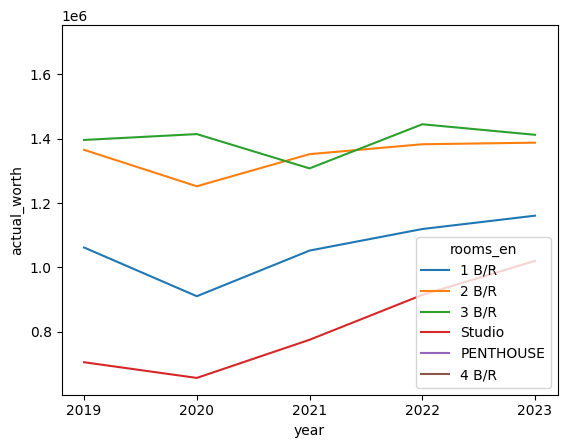

In [76]:
tmp = df_flat[(df_flat['year'].isin(['2019',
                                     '2020',
                                     '2021', 
                                     '2022', 
                                     '2023'])) & \
        (df_flat['id'].isin(unique_id))
        ].groupby(['year', 'rooms_en']).actual_worth.mean()

tmp = pd.DataFrame(tmp).reset_index()
sns.lineplot(x='year', y='actual_worth', hue='rooms_en', data=tmp)

In [87]:
def region_analytics(df, target_type, target):
    
    unique_id = df_flat[df_flat[target_type] == target].id.unique()
    
    tmp = df_flat[(df_flat['year'].isin(['2019',
                                     '2020',
                                     '2021', 
                                     '2022', 
                                     '2023',
                                        '2024'])) & \
        (df_flat['id'].isin(unique_id))
        ].groupby(['year', 'rooms_en']).actual_worth.mean()

    tmp = pd.DataFrame(tmp).reset_index()
    
    return sns.lineplot(x='year', y='actual_worth', hue='rooms_en', data=tmp)

<Axes: xlabel='year', ylabel='actual_worth'>

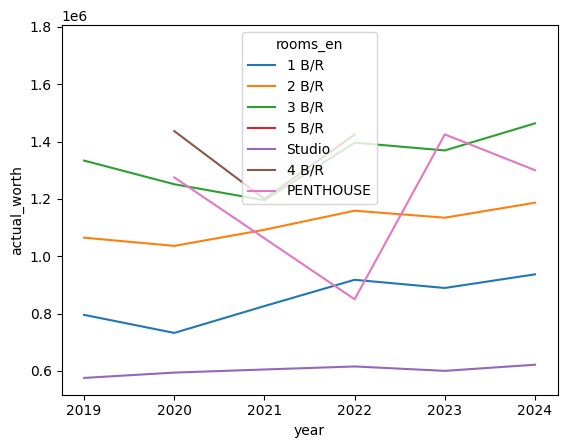

In [88]:
region_analytics(df = df_flat,
                 target_type = 'nearest_mall_en', 
                 target = 'Marina Mall')

In [96]:
tmp = df_flat[(df_flat['year'].isin(['2019', '2020', '2021', '2022', '2024'])) & (df_flat['id'].isin(unique_id))].groupby(['year', 'rooms_en']).actual_worth.mean()


In [100]:
pd.DataFrame(tmp).reset_index()

,year,rooms_en,actual_worth
0,2019,1 B/R,1.061836e+06
1,2019,2 B/R,1.365050e+06
2,2019,3 B/R,1.395684e+06
3,2019,Studio,7.056807e+05
4,2020,1 B/R,9.106342e+05
5,2020,2 B/R,1.251956e+06
6,2020,3 B/R,1.413909e+06
7,2020,PENTHOUSE,1.162500e+06
8,2020,Studio,6.570292e+05
9,2021,1 B/R,1.052298e+06


<Axes: xlabel='year', ylabel='actual_worth'>

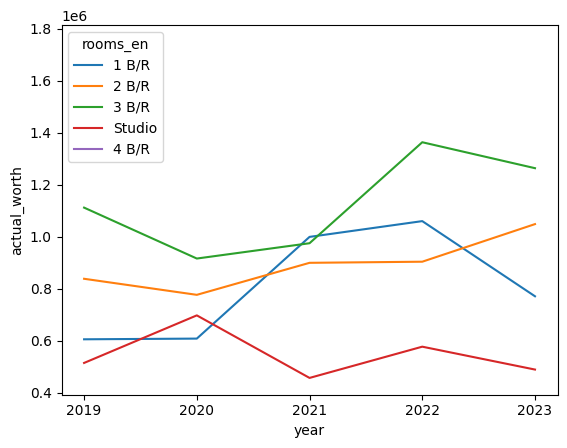

In [65]:
sns.lineplot(x='year', y='actual_worth', hue='rooms_en', data=tmp)

In [22]:
df_flat[df_flat['nearest_metro_en'] == 'Jumeirah Beach Residency']

547865    2380333316582382778
399216    7112545009541282026
620008    1475233744480925847
470785    4951032783612517864
252430    5742936047328818599
                 ...         
320721    6140914023799933788
91467     1804057388755230291
906410    5363692882951971226
674123    8283104626084315020
525035     786796445301940777
Name: id, Length: 1477, dtype: int64

In [27]:
df_flat.

547865    2007
399216    2007
620008    2007
470785    2007
252430    2007
          ... 
525035    2024
524536    2024
793451    2024
842645    2024
630781    2024
Name: year, Length: 71083, dtype: object

In [25]:
df_flat['rooms_en']

547865     2 B/R
399216     3 B/R
620008     2 B/R
470785     2 B/R
252430     2 B/R
           ...  
525035    Studio
524536    Studio
793451    Studio
842645     2 B/R
630781     1 B/R
Name: rooms_en, Length: 71083, dtype: object